# English Character Recognition in Natural Images (testing)

## Load dataset for the testing process

In [1]:
import json
import os

import cv2
import numpy as np
import pandas as pd

from typing import List

### Load the class names mapping

In [2]:
DATASET_DIR = os.path.join("dataset")
with open(os.path.join(DATASET_DIR, "class_names.json"), "r") as fp:
    class_names = json.load(fp)
    class_names = {int(k): v for k, v in class_names.items()}

### Create PyTorch dataset with an image preprocessing pipeline

In [3]:
import torch

from chars74k import Chars74kDataset
from torch.utils.data import DataLoader

In [4]:
ds_test = Chars74kDataset(DATASET_DIR, "test")

### Create PyTorch data loader

In [5]:
BATCH_SIZE = 64
loader_test = DataLoader(ds_test, batch_size=BATCH_SIZE, num_workers=8)

## Model testing

In [6]:
import models

from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, accuracy_score

### Which device we will use for testing process (CPU/GPU)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Create the model

In [8]:
model = models.CNN5HiddenLayers(n_classes=len(class_names))
# Move the model from CPU to the device
# Actually, only required if the device is not CPU and has no effect if it is CPU
model = model.to(device)

### Load the trained weights of the model parameters

In [9]:
WEIGHT_PATH = os.path.join("runs_clf", "train_20221001_124052", "best.pt")
model.load_state_dict(torch.load(WEIGHT_PATH))

<All keys matched successfully>

### The testing process

In [10]:
# We don't need gradients for the model testing process
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for i, vdata in tqdm(enumerate(loader_test)):
        vinputs, vlabels = vdata
        y_true.extend(vlabels.numpy().tolist())
        voutputs = model(vinputs.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(voutputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())

# Calculate our classification metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")
print(f'Accuracy: {acc}, Weighted F1: {f1}')


0it [00:00, ?it/s]

Accuracy: 0.5340687865022713, Weighted F1: 0.5255123274928825


## Visualize

In [11]:
import matplotlib.pyplot as plt

In [16]:
def im_convert(tensor):  
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image *= 255
    image = image.clip(0, 255).astype(np.uint8)
    return image

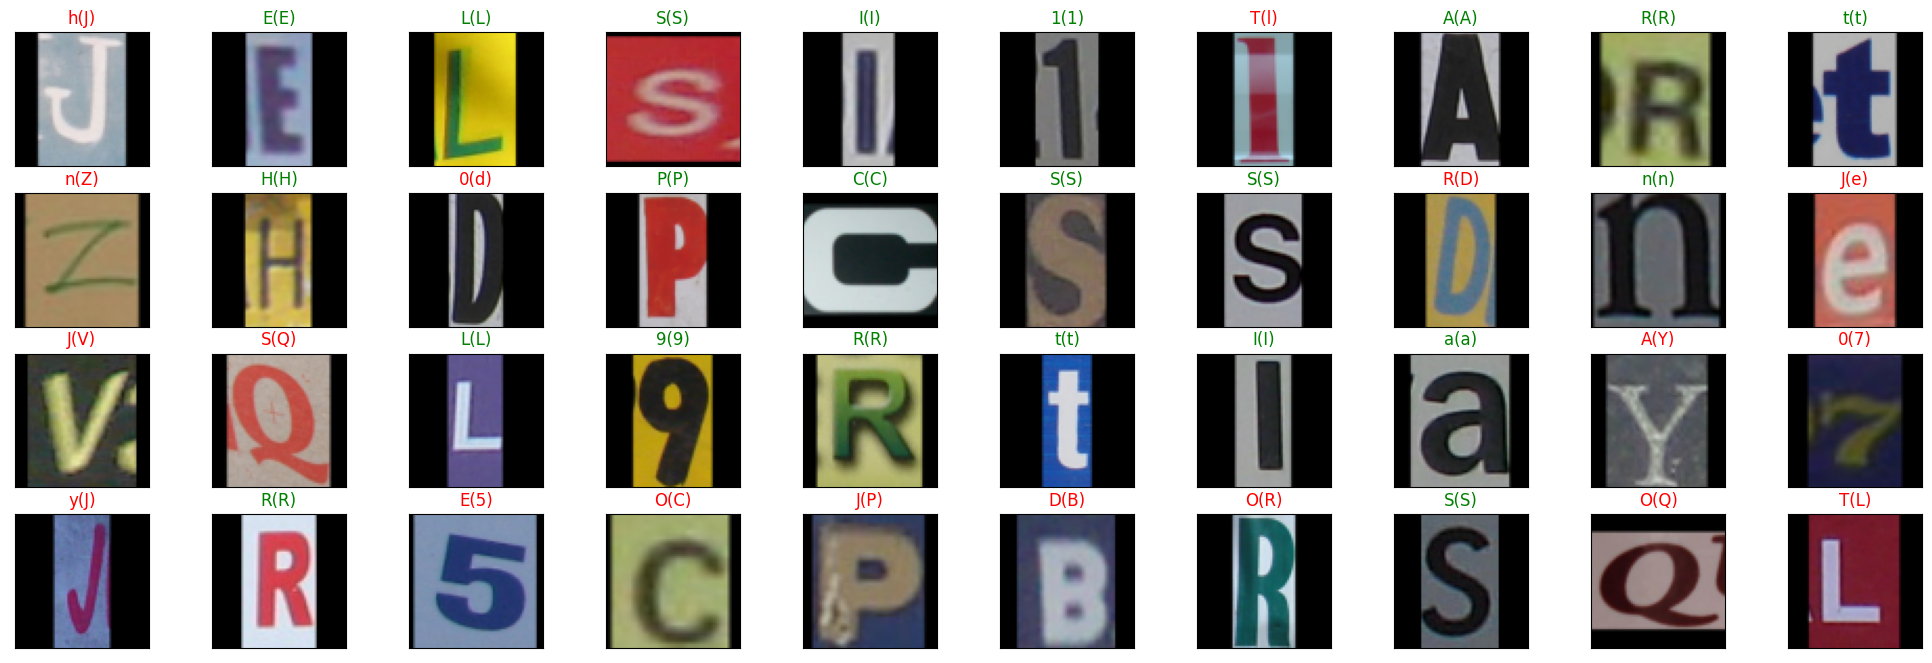

In [20]:
with torch.no_grad():
    dataiter = iter(loader_test)
    vinputs, vlabels = dataiter.next()
    voutputs = model(vinputs.to(device))
    _, predicted = torch.max(voutputs.data, 1)

fig=plt.figure(figsize=(25,8))  
for idx in np.arange(40):  
    ax=fig.add_subplot(4,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(vinputs[idx]))  
    ax.set_title(
        "{}({})".format(class_names[predicted[idx].item()], class_names[vlabels[idx].item()]),
        color=("green" if predicted[idx]==vlabels[idx] else "red"))  